In [ ]:
# 1. 라이브러리 설치
!pip install -q google-genai

In [ ]:
# 2. 라이브러리 임포트
import google.generativeai as genai # 공식 문서 권장 최신 임포트 방식
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import json
import time
from tqdm import tqdm # 진행 상황 표시
import platform # 시스템 정보 확인용
import psutil # 시스템 메모리 확인용
import torch # GPU 확인용 (PyTorch가 설치되어 있다는 가정)
import sys # Python 버전 확인용
import concurrent.futures # 병렬 처리

In [ ]:
# 3. API 키 설정 및 Gemini 모델 초기화
# Colab의 '비밀(Secrets)' 기능을 사용하는 것이 더 안전합니다.
from google.colab import userdata
API_KEY = userdata.get('GOOGLE_API_KEY_2')

# 모델 설정
# 참고: gemini-1.5-flash-latest 는 2024년 5월 기준 최신 Flash 모델 중 하나입니다.
# 모델명은 변경될 수 있으니, 필요시 Google AI 문서를 확인하여 최신 모델로 업데이트하세요.
MODEL_NAME = "gemini-2.0-flash-001"

generation_config = {
  "temperature": 0.1, # 예측의 일관성을 위해 낮은 값으로 설정
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 8192, # 모델의 최대 출력 토큰 수 (JSON 응답을 충분히 받을 수 있도록)
  "response_mime_type": "application/json", # 응답 형식을 JSON으로 명시
}

safety_settings = [
    {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"},
]

try:
    model = genai.GenerativeModel(
        model_name=MODEL_NAME,
        safety_settings=safety_settings,
        generation_config=generation_config
    )
    print(f"Gemini 모델 ({MODEL_NAME}) 초기화 성공.")
except Exception as e:
    print(f"Gemini 모델 초기화 실패: {e}")
    # 모델 초기화 실패 시 이후 코드 실행 의미 없음
    sys.exit()

In [ ]:
# 사용 가능한 모델 확인 (필요시)
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.5-flash-preview-04-17-thinking
models/gemini-2.5-pro-preview-05-06
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro

In [ ]:
# 4. 분석 환경 정보 출력 함수
def print_analysis_environment():
    print("--- 분석 환경 정보 ---")
    print(f"  Python 버전: {sys.version.split()[0]}")
    print(f"  google-generativeai 라이브러리 버전: {genai.__version__}")
    print(f"  운영 체제: {platform.system()} {platform.release()}")
    print(f"  프로세서: {platform.processor()}")
    ram_total_gb = psutil.virtual_memory().total / (1024**3)
    ram_available_gb = psutil.virtual_memory().available / (1024**3)
    print(f"  RAM: 총 {ram_total_gb:.2f} GB / 사용 가능 {ram_available_gb:.2f} GB")
    if torch.cuda.is_available():
        print(f"  GPU 할당됨: {torch.cuda.get_device_name(0)}")
        print(f"  CUDA 버전: {torch.version.cuda}")
    else:
        print("  GPU 할당되지 않음 (CPU 사용)")
    print(f"  사용된 Gemini 모델: {MODEL_NAME}")
    print("-" * 20)

print_analysis_environment()

--- 분석 환경 정보 ---
  Python 버전: 3.11.12
  google-generativeai 라이브러리 버전: 0.8.5
  운영 체제: Linux 6.1.123+
  프로세서: x86_64
  RAM: 총 12.67 GB / 사용 가능 10.97 GB
  GPU 할당됨: Tesla T4
  CUDA 버전: 12.4
  사용된 Gemini 모델: gemini-2.0-flash-001
--------------------


In [ ]:
# 5. 데이터 로드 및 전처리
# Colab 환경에서 파일 업로드
from google.colab import files
print("\n'test_data_1000.csv' 파일을 업로드해주세요.")
uploaded = files.upload()

if not uploaded:
    print("파일이 업로드되지 않았습니다. 스크립트를 종료합니다.")
    sys.exit()

file_name = list(uploaded.keys())[0]
try:
    df = pd.read_csv(file_name)
    print(f"'{file_name}' 로드 성공.")
except Exception as e:
    print(f"CSV 파일 로드 중 오류 발생: {e}")
    sys.exit()

# 정답 레이블 컬럼 정의
label_columns = ['sentiment', '맛', '식감', '기타', '가격', '주관적평가']

# 정답 레이블과 댓글(comment) 분리
if not all(col in df.columns for col in label_columns + ['comment', 'ID']):
    print(f"필수 컬럼({label_columns + ['comment', 'ID']})이 파일에 모두 존재하지 않습니다. 컬럼명을 확인해주세요.")
    sys.exit()

true_labels_df = df[label_columns].copy()
comments = df['comment'].tolist()
ids = df['ID'].tolist() # ID는 추후 결과 매칭 및 상세 분석에 유용

print(f"데이터 준비 완료. 분석할 댓글 수: {len(comments)}")


'test_data_1000.csv' 파일을 업로드해주세요.


Saving test_data_1000.csv to test_data_1000.csv
'test_data_1000.csv' 로드 성공.
데이터 준비 완료. 분석할 댓글 수: 1000


In [ ]:
# 6. Gemini 예측 수행 함수 (단일 댓글 처리 및 결과에 ID 포함)
def process_single_comment_with_id(comment_id, comment_text, retry_delay_base=0.5):
    """단일 댓글에 대해 Gemini API를 호출하고, ID와 함께 결과를 반환합니다."""
    # print(f"  ID {comment_id}: 처리 시작...") # 디버깅 시 개별 스레드 시작 확인
    base_prompt_template = """
    당신은 편의점 제품 리뷰의 댓글을 분석하여 다중 속성에 대한 감성을 분류하는 전문가입니다.
    다음 댓글을 읽고, 아래 6가지 속성에 대한 감성을 '긍정' 또는 '부정'으로만 분류해주세요.
    각 속성에 대한 언급이 댓글에 없거나 판단이 매우 어려운 경우, 가장 중립적이거나 알 수 없다는 의미로 '부정'으로 분류해주세요.
    반드시 JSON 형식으로 답변해야 하며, 다른 설명은 포함하지 마세요.

    댓글: "{comment_text}"

    분석 결과 (JSON 형식, 값은 "긍정" 또는 "부정"만 사용):
    {{
      "sentiment": "...",
      "맛": "...",
      "식감": "...",
      "기타": "...",
      "가격": "...",
      "주관적평가": "..."
    }}
    """
    current_prompt = base_prompt_template.format(comment_text=comment_text)
    max_retries = 3
    attempt = 0
    default_prediction = {col: 0 for col in label_columns}

    while attempt < max_retries:
        # print(f"    ID {comment_id}: API 호출 시도 ({attempt + 1}/{max_retries})") # 디버깅
        try:
            response = model.generate_content(current_prompt)
            predicted_data_from_api = None

            if hasattr(response, 'text') and response.text:
                # print(f"      ID {comment_id}: 응답 텍스트 받음: {response.text[:60]}...") # 디버깅
                if isinstance(response.text, str):
                    try:
                        predicted_data_from_api = json.loads(response.text)
                    except json.JSONDecodeError:
                        clean_text = response.text.strip().removeprefix("```json").removesuffix("```").strip()
                        predicted_data_from_api = json.loads(clean_text)
                else: predicted_data_from_api = response.text
            elif hasattr(response, 'parts') and response.parts:
                 part_text = response.parts[0].text
                 # print(f"      ID {comment_id}: 응답 파트 텍스트 받음: {part_text[:60]}...") # 디버깅
                 if isinstance(part_text, str):
                    try:
                        predicted_data_from_api = json.loads(part_text)
                    except json.JSONDecodeError:
                        clean_text = part_text.strip().removeprefix("```json").removesuffix("```").strip()
                        predicted_data_from_api = json.loads(clean_text)
                 else: predicted_data_from_api = part_text

            if predicted_data_from_api is None:
                raise ValueError("응답에서 유효한 텍스트 또는 파트를 찾을 수 없습니다.")

            # print(f"      ID {comment_id}: JSON 파싱 시도 결과: {predicted_data_from_api}") # 디버깅
            processed_single_prediction = {}
            valid_response = True
            for col_name in label_columns:
                value = predicted_data_from_api.get(col_name)
                if value not in ["긍정", "부정"]:
                    print(f"  ID {comment_id}: 속성 '{col_name}'에 예기치 않은 값 '{value}'. 응답 전체: {predicted_data_from_api}")
                    valid_response = False; break
                processed_single_prediction[col_name] = 1 if value == "긍정" else 0

            if valid_response:
                # print(f"    ID {comment_id}: 유효한 응답 처리 완료.") # 디버깅
                return {'ID': comment_id, **processed_single_prediction}

            attempt += 1
            print(f"  ID {comment_id}: 유효하지 않은 응답으로 재시도 ({attempt}/{max_retries}).")
            if attempt < max_retries: time.sleep(retry_delay_base * (2**attempt))

        except json.JSONDecodeError as e_json:
            attempt += 1
            print(f"  ID {comment_id}: JSON 파싱 오류 (시도 {attempt}/{max_retries}): {e_json}")
            if hasattr(response, 'text') and response.text: print(f"    받은 텍스트: {response.text[:100]}...")
            elif hasattr(response, 'parts') and response.parts and response.parts[0].text: print(f"    받은 파트 텍스트: {response.parts[0].text[:100]}...")
            if attempt < max_retries: time.sleep(retry_delay_base * (2**attempt))
        except Exception as e_api:
            attempt += 1
            print(f"  ID {comment_id}: API 호출/처리 중 오류 (시도 {attempt}/{max_retries}): {type(e_api).__name__} - {str(e_api)[:100]}...")
            error_str = str(e_api).lower()
            if "quota" in error_str or "rate limit" in error_str or "429" in error_str or "resource has been exhausted" in error_str:
                wait_time = retry_delay_base * (2**(attempt + 2)) # 할당량 초과 시 더 긴 대기
                print(f"    할당량 초과 가능성. {wait_time:.1f}초 대기 후 재시도...")
                time.sleep(wait_time)
            elif attempt < max_retries:
                time.sleep(retry_delay_base * (2**attempt))

    print(f"ID {comment_id}: 최대 재시도 후에도 처리 실패. 기본값으로 처리.")
    return {'ID': comment_id, **default_prediction}

In [ ]:
# 7. 대량 예측 수행 (ThreadPoolExecutor 사용 및 결과 순서 보장)
print(f"\nGemini ({MODEL_NAME})를 사용한 대량 예측을 시작합니다 (병렬 처리)...")

# MAX_WORKERS: RPM 4000 -> 초당 ~66 요청. 네트워크 지연 및 API 응답 시간 고려.
# 처음에는 5~10 정도로 시작하여 API 오류(특히 429) 발생 빈도를 보며 조절.
# Colab Free tier 일일 총 요청량 제한(500 req/day 등)도 반드시 고려. 1000개는 유료 플랜 권장.
MAX_WORKERS = 10 # <<--- 시작 값으로 낮게 설정. 5, 10, 15, 20 순으로 늘려가며 테스트.
print(f"  설정된 MAX_WORKERS: {MAX_WORKERS}")

results_with_ids = []
overall_start_time = time.time()

try:
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        print(f"  ThreadPoolExecutor 생성 완료. 작업 제출 시작...")
        # 작업 제출: executor.submit(함수, 인자1, 인자2, ...)
        future_to_id = {
            executor.submit(process_single_comment_with_id, ids[i], comments[i]): ids[i]
            for i in range(len(comments))
        }
        print(f"  총 {len(future_to_id)}개의 작업이 executor에 제출되었습니다.")

        # tqdm을 사용하여 진행 상황 표시
        for future in tqdm(concurrent.futures.as_completed(future_to_id), total=len(comments), desc="Gemini 병렬 예측 진행 중", mininterval=1.0):
            comment_id_completed = future_to_id[future]
            # print(f"  ID {comment_id_completed} 작업 완료 시도... (tqdm 진행 중)") # 너무 많은 로그 방지 위해 주석 처리
            try:
                prediction_result_with_id = future.result() # 여기서 실제 함수 실행 결과 대기
                results_with_ids.append(prediction_result_with_id)
            except Exception as exc_future: # future.result() 자체에서 발생할 수 있는 예외
                print(f'    ID {comment_id_completed}의 future.result()에서 예외 발생: {type(exc_future).__name__} - {str(exc_future)}')
                default_prediction = {col: 0 for col in label_columns}
                results_with_ids.append({'ID': comment_id_completed, **default_prediction})
        print("  모든 future 작업 완료 (as_completed 루프 종료).")

except Exception as e_executor: # ThreadPoolExecutor 자체의 문제 또는 다른 예기치 않은 문제
    print(f"ThreadPoolExecutor 실행 중 심각한 오류 발생: {e_executor}")


overall_end_time = time.time()
total_inference_time_seconds = overall_end_time - overall_start_time
avg_inference_time_per_comment_seconds = total_inference_time_seconds / len(comments) if comments else 0

# 결과 순서를 원본 ID 순서대로 정렬
if results_with_ids and all('ID' in res for res in results_with_ids): # ID 키 존재 확인
    try:
        original_id_order_map = {id_val: i for i, id_val in enumerate(ids)}
        sorted_results_with_ids = sorted(results_with_ids, key=lambda x: original_id_order_map.get(x['ID'], float('inf'))) # 없는 ID는 맨 뒤로
        # 정렬 후 ID 누락 없는지 확인 (선택적)
        if len(sorted_results_with_ids) != len(ids):
            print(f"Warning: 정렬 후 결과 개수({len(sorted_results_with_ids)})가 원본 ID 개수({len(ids)})와 다릅니다.")

        gemini_predictions_list_of_dicts = [
            {k: v for k, v in res.items() if k != 'ID'} for res in sorted_results_with_ids
        ]
        gemini_predictions_df = pd.DataFrame(gemini_predictions_list_of_dicts)
        print("\nGemini 예측 완료 및 결과 정렬 완료.")
    except KeyError as e_key:
        print(f"결과 정렬 중 KeyError 발생: {e_key}. results_with_ids에 없는 ID가 original_id_order_map에 참조된 것 같습니다.")
        print("정렬되지 않은 결과로 DataFrame을 생성합니다 (순서 보장 안됨).")
        gemini_predictions_df = pd.DataFrame([res for res in results_with_ids if 'ID' in res]) # ID 제외
    except Exception as e_sort:
        print(f"결과 정렬 중 예기치 않은 오류 발생: {e_sort}")
        gemini_predictions_df = pd.DataFrame([res for res in results_with_ids if 'ID' in res])
else:
    print("오류: results_with_ids가 비어있거나 ID 키가 없어 정렬 및 DataFrame 생성을 진행할 수 없습니다.")
    gemini_predictions_df = pd.DataFrame() # 빈 DataFrame으로 초기화


print("--- 추론 성능 ---")
print(f"  MAX_WORKERS: {MAX_WORKERS}")
print(f"  총 분석 댓글 수: {len(comments)}")
print(f"  총 추론 시간: {total_inference_time_seconds:.2f} 초")
if comments:
    print(f"  댓글 당 평균 추론 시간: {avg_inference_time_per_comment_seconds:.4f} 초")
print("-" * 20)

if gemini_predictions_df.empty or len(gemini_predictions_df) != len(comments):
    print("오류: 예측 결과 생성 또는 정렬에 문제가 있습니다. DataFrame이 비어있거나 길이가 다릅니다.")
    print(f"  생성된 예측 DataFrame 행 수: {len(gemini_predictions_df)}, 실제 댓글 수: {len(comments)}")
else:
    print("\n정렬된 예측 결과 샘플 (DataFrame):")
    print(gemini_predictions_df.head())
    print("\n실제 정답 레이블 샘플 (DataFrame):")
    print(true_labels_df.head())


Gemini (gemini-2.0-flash-001)를 사용한 대량 예측을 시작합니다 (병렬 처리)...
  설정된 MAX_WORKERS: 10
  ThreadPoolExecutor 생성 완료. 작업 제출 시작...
  총 1000개의 작업이 executor에 제출되었습니다.


Gemini 병렬 예측 진행 중:   0%|          | 2/1000 [00:03<24:14,  1.46s/it]

  ID 5: API 호출/처리 중 오류 (시도 1/3): ConnectionError - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))...  ID 9: API 호출/처리 중 오류 (시도 1/3): ConnectionError - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))...

  ID 6: API 호출/처리 중 오류 (시도 1/3): ConnectionError - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))...


Gemini 병렬 예측 진행 중:   2%|▏         | 17/1000 [00:19<17:06,  1.04s/it]

  ID 19: API 호출/처리 중 오류 (시도 1/3): ConnectionError - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))...


Gemini 병렬 예측 진행 중:  31%|███▏      | 314/1000 [05:17<11:23,  1.00it/s]

  ID 316: API 호출/처리 중 오류 (시도 1/3): ConnectionError - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))...


Gemini 병렬 예측 진행 중:  47%|████▋     | 470/1000 [07:59<08:58,  1.02s/it]

  ID 472: API 호출/처리 중 오류 (시도 1/3): AttributeError - 'list' object has no attribute 'get'...


Gemini 병렬 예측 진행 중:  95%|█████████▌| 952/1000 [16:27<00:49,  1.04s/it]

  ID 953: API 호출/처리 중 오류 (시도 1/3): ConnectionError - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))...


Gemini 병렬 예측 진행 중: 100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]

  모든 future 작업 완료 (as_completed 루프 종료).

Gemini 예측 완료 및 결과 정렬 완료.
--- 추론 성능 ---
  MAX_WORKERS: 10
  총 분석 댓글 수: 1000
  총 추론 시간: 1036.45 초
  댓글 당 평균 추론 시간: 1.0365 초
--------------------

정렬된 예측 결과 샘플 (DataFrame):
   sentiment  맛  식감  기타  가격  주관적평가
0          1  1   1   1   0      1
1          1  1   0   1   1      1
2          0  0   0   0   0      0
3          1  1   1   1   1      1
4          1  1   1   1   0      1

실제 정답 레이블 샘플 (DataFrame):
   sentiment  맛  식감  기타  가격  주관적평가
0          1  1   1   1   1      1
1          1  1   0   1   1      1
2          0  1   0   0   0      1
3          1  1   1   0   1      1
4          1  1   1   1   0      1


In [ ]:
gemini_predictions_df.isnull().sum()

,0
sentiment,0
맛,0
식감,0
기타,0
가격,0
주관적평가,0


In [ ]:
def calculate_and_print_metrics(y_true, y_pred, attribute_name):
    """단일 속성에 대한 성능 지표를 계산하고 출력합니다."""
    accuracy = accuracy_score(y_true, y_pred)
    precision_m = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_m = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_m = f1_score(y_true, y_pred, average='macro', zero_division=0)

    present_labels = sorted(pd.unique(y_true.tolist() + y_pred.tolist()))
    target_labels_for_report = [l for l in [0, 1] if l in present_labels]

    if not target_labels_for_report:
        print(f"--- {attribute_name} 성능 (단일 클래스만 존재) ---")
        print(f"  Accuracy: {accuracy:.4f}")
        if present_labels: print(f"  모든 예측/실제가 '{present_labels[0]}'로 동일합니다.")
        # 이 경우 confusion_matrix는 단일 값만 있는 행렬이 될 수 있음. labels 명시로 2x2 유지 시도
        try:
            cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        except ValueError: # 만약 [0,1] 중 하나만 존재하면 오류 발생 가능 -> 있는 레이블만 사용
            cm = confusion_matrix(y_true, y_pred, labels=present_labels)

        print(f"  Confusion Matrix:\n{cm}\n")
        return {
            'attribute': attribute_name, 'accuracy': accuracy,
            'precision_macro': precision_m if precision_m else 0, # 단일 클래스면 macro 지표가 1 또는 0일 수 있음
            'recall_macro': recall_m if recall_m else 0,
            'f1_macro': f1_m if f1_m else 0,
            'f1_class_1': 0, 'f1_class_0': 0,
            'precision_class_1':0, 'recall_class_1':0,
            'precision_class_0':0, 'recall_class_0':0,
            'confusion_matrix_tn_fp_fn_tp': cm.ravel().tolist() if cm.size == 4 else ([cm[0,0],0,0,0] if cm.size==1 and present_labels[0]==0 else [0,0,0,cm[0,0]] if cm.size==1 and present_labels[0]==1 else [0,0,0,0])
        }

    precision_per_class = precision_score(y_true, y_pred, average=None, labels=target_labels_for_report, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, labels=target_labels_for_report, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=target_labels_for_report, zero_division=0)

    metrics_dict = {
        'attribute': attribute_name, 'accuracy': accuracy,
        'precision_macro': precision_m, 'recall_macro': recall_m, 'f1_macro': f1_m,
    }
    for i, label in enumerate(target_labels_for_report):
        metrics_dict[f'precision_class_{label}'] = precision_per_class[i]
        metrics_dict[f'recall_class_{label}'] = recall_per_class[i]
        metrics_dict[f'f1_class_{label}'] = f1_per_class[i]
    for label_val in [0, 1]: # 없는 클래스 지표는 0으로 초기화
        if f'f1_class_{label_val}' not in metrics_dict: metrics_dict[f'f1_class_{label_val}'] = 0
        if f'precision_class_{label_val}' not in metrics_dict: metrics_dict[f'precision_class_{label_val}'] = 0
        if f'recall_class_{label_val}' not in metrics_dict: metrics_dict[f'recall_class_{label_val}'] = 0

    cm = confusion_matrix(y_true, y_pred, labels=[0,1]) # TN, FP, FN, TP 순서로 고정
    metrics_dict['confusion_matrix_tn_fp_fn_tp'] = cm.ravel().tolist()

    print(f"--- {attribute_name} 성능 ---")
    print(f"  Accuracy: {metrics_dict['accuracy']:.4f}")
    print(f"  Precision (Macro): {metrics_dict['precision_macro']:.4f}")
    print(f"  Recall (Macro): {metrics_dict['recall_macro']:.4f}")
    print(f"  F1-Score (Macro): {metrics_dict['f1_macro']:.4f}")
    print(f"  F1-Score (Positive=1): {metrics_dict.get('f1_class_1', 0):.4f}")
    print(f"  F1-Score (Negative=0): {metrics_dict.get('f1_class_0', 0):.4f}")
    # (필요시) 클래스별 정밀도, 재현율도 출력
    print(f"  Confusion Matrix (TN, FP, FN, TP):\n{cm}\n  (TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]})")
    return metrics_dict

# 9. 각 속성별 성능 평가 실행
all_calculated_metrics = []
# gemini_predictions_df는 이제 원본 ID 순서로 정렬되었으므로, true_labels_df와 직접 비교 가능
if not gemini_predictions_df.empty and len(gemini_predictions_df) == len(true_labels_df):
    for col_name in label_columns:
        if col_name in true_labels_df.columns and col_name in gemini_predictions_df.columns:
            true_values = true_labels_df[col_name]
            predicted_values = gemini_predictions_df[col_name]
            if predicted_values.isnull().any():
                print(f"Warning: 예측 값에 NaN이 포함되어 있습니다 ({col_name}). 0으로 대체합니다.")
                predicted_values = predicted_values.fillna(0).astype(int)
            metric_results = calculate_and_print_metrics(true_values, predicted_values, col_name)
            all_calculated_metrics.append(metric_results)
        else:
            print(f"경고: '{col_name}' 컬럼이 정답 또는 예측 DataFrame에 존재하지 않아 해당 속성 평가를 건너<0xEB><0x9C><0x84>니다.")
else:
    print("오류: 예측 결과 DataFrame이 비어있거나, 실제 정답과 예측 결과의 길이가 일치하지 않습니다. 성능 평가를 진행할 수 없습니다.")


# 10. 종합 성능 지표 및 요약 테이블 출력
if all_calculated_metrics:
    avg_macro_f1_all = sum(m['f1_macro'] for m in all_calculated_metrics) / len(all_calculated_metrics)
    avg_positive_f1_all = sum(m.get('f1_class_1', 0) for m in all_calculated_metrics) / len(all_calculated_metrics)
    print(f"--- 전체 속성에 대한 종합 성능 (평균) ---")
    print(f"  모든 속성의 평균 Macro F1-Score: {avg_macro_f1_all:.4f}")
    print(f"  모든 속성의 평균 F1-Score (Positive=1): {avg_positive_f1_all:.4f}")
    print("-" * 20)
    metrics_summary_df = pd.DataFrame(all_calculated_metrics)
    print("\n--- 개별 속성별 성능 요약 테이블 ---")
    display_cols = ['attribute', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                    'f1_class_1', 'f1_class_0', 'precision_class_1', 'recall_class_1',
                    'precision_class_0', 'recall_class_0']
    print(metrics_summary_df[display_cols])
else:
    print("계산된 성능 지표가 없어 종합 성능 요약 테이블을 출력할 수 없습니다.")

# 11. 결과 파일 저장
if not gemini_predictions_df.empty and len(gemini_predictions_df) == len(df):
    output_df = df[['ID', 'comment']].copy() # 원본 ID와 comment 사용
    # true_labels_df와 gemini_predictions_df는 이제 원본 ID 순서와 동일
    for col_name in label_columns:
        output_df[f'실제_{col_name}'] = true_labels_df[col_name].values
        if col_name in gemini_predictions_df.columns:
             output_df[f'예측_{col_name}'] = gemini_predictions_df[col_name].values
        else: # 혹시 모를 상황 대비
             output_df[f'예측_{col_name}'] = pd.NA

    output_csv_filename = f"gemini_{MODEL_NAME.replace('/', '_')}_predictions_summary_parallel_ordered.csv"
    output_df.to_csv(output_csv_filename, index=False, encoding='utf-8-sig')
    print(f"\n최종 예측 결과와 실제 정답이 포함된 파일이 '{output_csv_filename}'으로 저장되었습니다.")
else:
    print("최종 예측 결과 DataFrame이 비어있거나 원본 데이터와 길이가 일치하지 않아, 결과 파일을 저장하지 않습니다.")

--- sentiment 성능 ---
  Accuracy: 0.9890
  Precision (Macro): 0.9940
  Recall (Macro): 0.9368
  F1-Score (Macro): 0.9633
  F1-Score (Positive=1): 0.9940
  F1-Score (Negative=0): 0.9325
  Confusion Matrix (TN, FP, FN, TP):
[[ 76  11]
 [  0 913]]
  (TN=76, FP=11, FN=0, TP=913)
--- 맛 성능 ---
  Accuracy: 0.9160
  Precision (Macro): 0.5752
  Recall (Macro): 0.7228
  F1-Score (Macro): 0.6028
  F1-Score (Positive=1): 0.9555
  F1-Score (Negative=0): 0.2500
  Confusion Matrix (TN, FP, FN, TP):
[[ 14  13]
 [ 71 902]]
  (TN=14, FP=13, FN=71, TP=902)
--- 식감 성능 ---
  Accuracy: 0.7940
  Precision (Macro): 0.7838
  Recall (Macro): 0.7551
  F1-Score (Macro): 0.7649
  F1-Score (Positive=1): 0.8476
  F1-Score (Negative=0): 0.6821
  Confusion Matrix (TN, FP, FN, TP):
[[221 136]
 [ 70 573]]
  (TN=221, FP=136, FN=70, TP=573)
--- 기타 성능 ---
  Accuracy: 0.4540
  Precision (Macro): 0.5987
  Recall (Macro): 0.5736
  F1-Score (Macro): 0.4468
  F1-Score (Positive=1): 0.5099
  F1-Score (Negative=0): 0.3837
  Confusi

<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() + y_pred.tolist()))
<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() + y_pred.tolist()))
<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() + y_pred.tolist()))
<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() 

In [ ]:
# 9. 각 속성별 성능 평가 실행
all_calculated_metrics = []
if not gemini_predictions_df.empty and len(gemini_predictions_df) == len(true_labels_df):
    for col_name in label_columns:
        if col_name in true_labels_df.columns and col_name in gemini_predictions_df.columns:
            true_values = true_labels_df[col_name].astype(int) # 정수형으로 변환
            predicted_values = gemini_predictions_df[col_name].fillna(0).astype(int) # NaN은 0으로 채우고 정수형으로

            if predicted_values.isnull().any(): # 위에서 fillna 했으므로 이 부분은 실행되지 않아야 함
                print(f"Critical Warning: 예측 값에 여전히 NaN이 포함되어 있습니다 ({col_name}).")
            metric_results = calculate_and_print_metrics(true_values, predicted_values, col_name)
            all_calculated_metrics.append(metric_results)
        else:
            print(f"경고: '{col_name}' 컬럼이 정답 또는 예측 DataFrame에 존재하지 않아 해당 속성 평가를 건너<0xEB><0x9C><0x84>니다.")
else:
    print("오류: 예측 결과 DataFrame이 비어있거나, 실제 정답과 예측 결과의 길이가 일치하지 않습니다. 성능 평가를 진행할 수 없습니다.")

--- sentiment 성능 ---
  Accuracy: 0.9890
  Precision (Macro): 0.9940
  Recall (Macro): 0.9368
  F1-Score (Macro): 0.9633
  F1-Score (Positive=1): 0.9940
  F1-Score (Negative=0): 0.9325
  Confusion Matrix (TN, FP, FN, TP):
[[ 76  11]
 [  0 913]]
  (TN=76, FP=11, FN=0, TP=913)
--- 맛 성능 ---
  Accuracy: 0.9160
  Precision (Macro): 0.5752
  Recall (Macro): 0.7228
  F1-Score (Macro): 0.6028
  F1-Score (Positive=1): 0.9555
  F1-Score (Negative=0): 0.2500
  Confusion Matrix (TN, FP, FN, TP):
[[ 14  13]
 [ 71 902]]
  (TN=14, FP=13, FN=71, TP=902)
--- 식감 성능 ---
  Accuracy: 0.7940
  Precision (Macro): 0.7838
  Recall (Macro): 0.7551
  F1-Score (Macro): 0.7649
  F1-Score (Positive=1): 0.8476
  F1-Score (Negative=0): 0.6821
  Confusion Matrix (TN, FP, FN, TP):
[[221 136]
 [ 70 573]]
  (TN=221, FP=136, FN=70, TP=573)
--- 기타 성능 ---
  Accuracy: 0.4540
  Precision (Macro): 0.5987
  Recall (Macro): 0.5736
  F1-Score (Macro): 0.4468
  F1-Score (Positive=1): 0.5099
  F1-Score (Negative=0): 0.3837
  Confusi

<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() + y_pred.tolist()))
<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() + y_pred.tolist()))
<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() + y_pred.tolist()))
<ipython-input-9-734ba75b5b78>:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  present_labels = sorted(pd.unique(y_true.tolist() 

---

In [ ]:
# 10. 종합 성능 지표 및 요약 테이블 출력
if all_calculated_metrics:
    avg_macro_f1_all = sum(m['f1_macro'] for m in all_calculated_metrics) / len(all_calculated_metrics)
    avg_positive_f1_all = sum(m.get('f1_class_1', 0.0) for m in all_calculated_metrics) / len(all_calculated_metrics)
    print(f"\n--- 전체 속성에 대한 종합 성능 (평균) ---")
    print(f"  모든 속성의 평균 Macro F1-Score: {avg_macro_f1_all:.4f}")
    print(f"  모든 속성의 평균 F1-Score (Positive=1): {avg_positive_f1_all:.4f}")
    print("-" * 20)
    metrics_summary_df = pd.DataFrame(all_calculated_metrics)
    print("\n--- 개별 속성별 성능 요약 테이블 ---")
    display_cols = ['attribute', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                    'f1_class_1', 'f1_class_0', 'precision_class_1', 'recall_class_1',
                    'precision_class_0', 'recall_class_0', 'confusion_matrix_tn_fp_fn_tp']
    print(metrics_summary_df[display_cols])
else:
    print("계산된 성능 지표가 없어 종합 성능 요약 테이블을 출력할 수 없습니다.")

# 11. 결과 파일 저장
if not gemini_predictions_df.empty and len(gemini_predictions_df) == len(df):
    output_df = df[['ID', 'comment']].copy()
    for col_name in label_columns:
        # true_labels_df와 gemini_predictions_df는 이제 원본 ID 순서와 동일 (정렬됨)
        output_df[f'실제_{col_name}'] = true_labels_df[col_name].values
        if col_name in gemini_predictions_df.columns:
             output_df[f'예측_{col_name}'] = gemini_predictions_df[col_name].values
        else:
             output_df[f'예측_{col_name}'] = pd.NA # 예측 없는 경우 NA

    output_csv_filename = f"gemini_{MODEL_NAME.replace('/', '_')}_predictions_final_ordered.csv"
    output_df.to_csv(output_csv_filename, index=False, encoding='utf-8-sig')
    print(f"\n최종 예측 결과와 실제 정답이 포함된 파일이 '{output_csv_filename}'으로 저장되었습니다.")
else:
    print("최종 예측 결과 DataFrame이 비어있거나 원본 데이터와 길이가 일치하지 않아, 결과 파일을 저장하지 않습니다.")


--- 전체 속성에 대한 종합 성능 (평균) ---
  모든 속성의 평균 Macro F1-Score: 0.6910
  모든 속성의 평균 F1-Score (Positive=1): 0.8333
--------------------

--- 개별 속성별 성능 요약 테이블 ---
   attribute  accuracy  precision_macro  recall_macro  f1_macro  f1_class_1  \
0  sentiment     0.989         0.994048      0.936782  0.963264    0.994012   
1          맛     0.916         0.575249      0.722774  0.602754    0.955508   
2         식감     0.794         0.783815      0.755091  0.764866    0.847633   
3         기타     0.454         0.598737      0.573636  0.446811    0.509874   
4         가격     0.861         0.896238      0.790257  0.819161    0.732177   
5      주관적평가     0.925         0.536794      0.764141  0.549363    0.960795   

   f1_class_0  precision_class_1  recall_class_1  precision_class_0  \
0    0.932515           0.988095        1.000000           1.000000   
1    0.250000           0.985792        0.927030           0.164706   
2    0.682099           0.808181        0.891135           0.759450   
3    0.3

---

## 시각화 코드

In [ ]:
# 필요한 라이브러리 임포트
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Colab 환경에서 한글 폰트 깨짐 방지 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,613 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and dire

In [ ]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지

In [ ]:
all_calculated_metrics

[{'attribute': 'sentiment',
  'accuracy': 0.989,
  'precision_macro': 0.9940476190476191,
  'recall_macro': 0.9367816091954023,
  'f1_macro': 0.9632636567356085,
  'precision_class_0': np.float64(1.0),
  'recall_class_0': np.float64(0.8735632183908046),
  'f1_class_0': np.float64(0.9325153374233128),
  'precision_class_1': np.float64(0.9880952380952381),
  'recall_class_1': np.float64(1.0),
  'f1_class_1': np.float64(0.9940119760479041),
  'confusion_matrix_tn_fp_fn_tp': [76, 11, 0, 913]},
 {'attribute': '맛',
  'accuracy': 0.916,
  'precision_macro': 0.5752491160398586,
  'recall_macro': 0.7227741616230825,
  'f1_macro': 0.6027542372881356,
  'precision_class_0': np.float64(0.16470588235294117),
  'recall_class_0': np.float64(0.5185185185185185),
  'f1_class_0': np.float64(0.25),
  'precision_class_1': np.float64(0.985792349726776),
  'recall_class_1': np.float64(0.9270298047276464),
  'f1_class_1': np.float64(0.9555084745762712),
  'confusion_matrix_tn_fp_fn_tp': [14, 13, 71, 902]},
 

In [ ]:
metrics_summary_df = pd.DataFrame(all_calculated_metrics)
metrics_summary_df

,attribute,accuracy,precision_macro,recall_macro,f1_macro,precision_class_0,recall_class_0,f1_class_0,precision_class_1,recall_class_1,f1_class_1,confusion_matrix_tn_fp_fn_tp
0,sentiment,0.989,0.994048,0.936782,0.963264,1.000000,0.873563,0.932515,0.988095,1.000000,0.994012,"[76, 11, 0, 913]"
1,맛,0.916,0.575249,0.722774,0.602754,0.164706,0.518519,0.250000,0.985792,0.927030,0.955508,"[14, 13, 71, 902]"
2,식감,0.794,0.783815,0.755091,0.764866,0.759450,0.619048,0.682099,0.808181,0.891135,0.847633,"[221, 136, 70, 573]"
3,기타,0.454,0.598737,0.573636,0.446811,0.841584,0.248538,0.383747,0.355890,0.898734,0.509874,"[170, 514, 32, 284]"
4,가격,0.861,0.896238,0.790257,0.819161,0.837703,0.986765,0.906144,0.954774,0.593750,0.732177,"[671, 9, 130, 190]"
5,주관적평가,0.925,0.536794,0.764141,0.549363,0.077922,0.600000,0.137931,0.995666,0.928283,0.960795,"[6, 4, 71, 919]"


In [ ]:
from google.colab import files

# CSV 파일로 저장
csv_filename = 'metrics_summary.csv'
metrics_summary_df.to_csv(csv_filename, index=False)

# 다운로드 트리거
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 전체 평균 F1-Score 값 (이전 실행 결과에서 가져옴)
avg_f1_macro_all_attributes = 0.6910
avg_f1_positive_all_attributes = 0.8333 # Positive F1 (f1_class_1)의 평균

In [ ]:
# 영문 attribute 이름으로 변경 (선택적이지만, 그래프에 영어로 표시하기 위함)
attribute_english_map = {
    'sentiment': 'Overall Sentiment',
    '맛': 'Taste',
    '식감': 'Texture',
    '기타': 'Others',
    '가격': 'Price',
    '주관적평가': 'Subjective Eval'
}
metrics_summary_df['attribute_en'] = metrics_summary_df['attribute'].map(attribute_english_map)

<ipython-input-30-b4c03c91ebce>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, 0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=30, ha="right") # 수정된 부분
<ipython-input-30-b4c03c91ebce>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, 1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30, ha="right") # 수정된 부분
<ipython-input-30-b4c03c91ebce>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=30, ha="right") # 수정된 부분
<ipython-input-30-b4c03c91ebce>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=30, ha="right") #

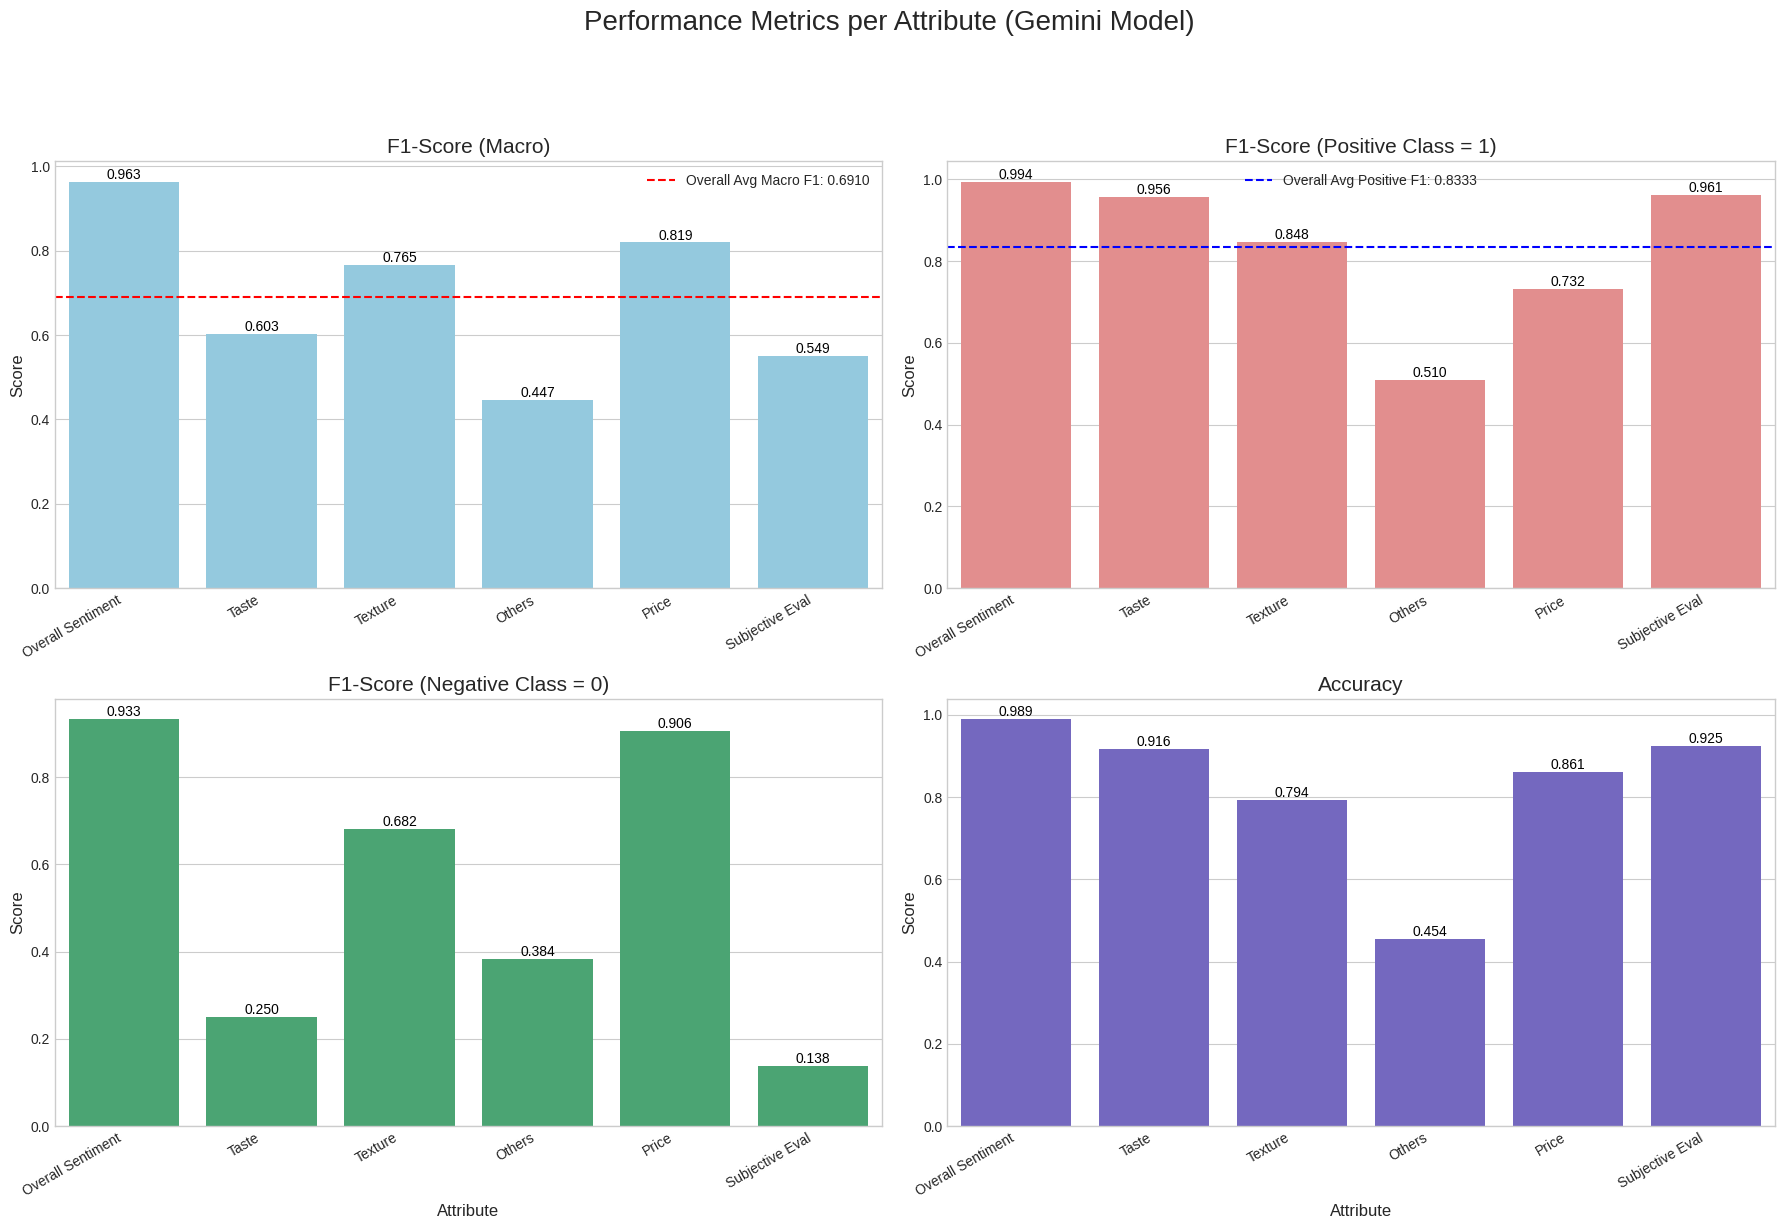

In [ ]:
# 시각화 1: 각 속성별 주요 F1-Score 및 정확도 비교 (영문)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 깨짐 방지 (이미 설정되어 있을 수 있음)

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Performance Metrics per Attribute (Gemini Model)', fontsize=20, y=1.02)

# 1. F1-Macro Score
# FutureWarning를 피하기 위해 hue를 명시적으로 사용하거나, palette를 color로 변경
# 여기서는 간단히 color를 사용하거나, palette를 그대로 두고 경고를 무시하는 방법이 있음
# sns.barplot(x='attribute_en', y='f1_macro', data=metrics_summary_df, ax=ax[0, 0], palette='viridis', dodge=False) # 이전 방식
sns.barplot(x='attribute_en', y='f1_macro', data=metrics_summary_df, ax=ax[0, 0], color='skyblue', dodge=False) # 단일 색상 사용
ax[0, 0].set_title('F1-Score (Macro)', fontsize=15)
ax[0, 0].set_ylabel('Score', fontsize=12)
ax[0, 0].set_xlabel('')
ax[0, 0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=30, ha="right") # 수정된 부분
ax[0, 0].axhline(avg_f1_macro_all_attributes, color='red', linestyle='--', label=f'Overall Avg Macro F1: {avg_f1_macro_all_attributes:.4f}')
ax[0, 0].legend()
for p in ax[0, 0].patches:
    ax[0, 0].annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# 2. F1-Score (Positive Class = 1)
sns.barplot(x='attribute_en', y='f1_class_1', data=metrics_summary_df, ax=ax[0, 1], color='lightcoral', dodge=False)
ax[0, 1].set_title('F1-Score (Positive Class = 1)', fontsize=15)
ax[0, 1].set_ylabel('Score', fontsize=12)
ax[0, 1].set_xlabel('')
ax[0, 1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=30, ha="right") # 수정된 부분
ax[0, 1].axhline(avg_f1_positive_all_attributes, color='blue', linestyle='--', label=f'Overall Avg Positive F1: {avg_f1_positive_all_attributes:.4f}')
ax[0, 1].legend()
for p in ax[0, 1].patches:
    ax[0, 1].annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# 3. F1-Score (Negative Class = 0)
sns.barplot(x='attribute_en', y='f1_class_0', data=metrics_summary_df, ax=ax[1, 0], color='mediumseagreen', dodge=False)
ax[1, 0].set_title('F1-Score (Negative Class = 0)', fontsize=15)
ax[1, 0].set_ylabel('Score', fontsize=12)
ax[1, 0].set_xlabel('Attribute', fontsize=12)
ax[1, 0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=30, ha="right") # 수정된 부분
for p in ax[1, 0].patches:
    ax[1, 0].annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# 4. Accuracy
sns.barplot(x='attribute_en', y='accuracy', data=metrics_summary_df, ax=ax[1, 1], color='slateblue', dodge=False)
ax[1, 1].set_title('Accuracy', fontsize=15)
ax[1, 1].set_ylabel('Score', fontsize=12)
ax[1, 1].set_xlabel('Attribute', fontsize=12)
ax[1, 1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=30, ha="right") # 수정된 부분
for p in ax[1, 1].patches:
    ax[1, 1].annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<ipython-input-25-51647ab8bdc2>:26: UserWarning: Glyph 47579 (\N{HANGUL SYLLABLE MAS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-25-51647ab8bdc2>:26: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-25-51647ab8bdc2>:26: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-25-51647ab8bdc2>:26: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-25-51647ab8bdc2>:26: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-25-51647ab8bdc2>:26: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-25-51647ab8bdc2>:26: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Liberation Sans.


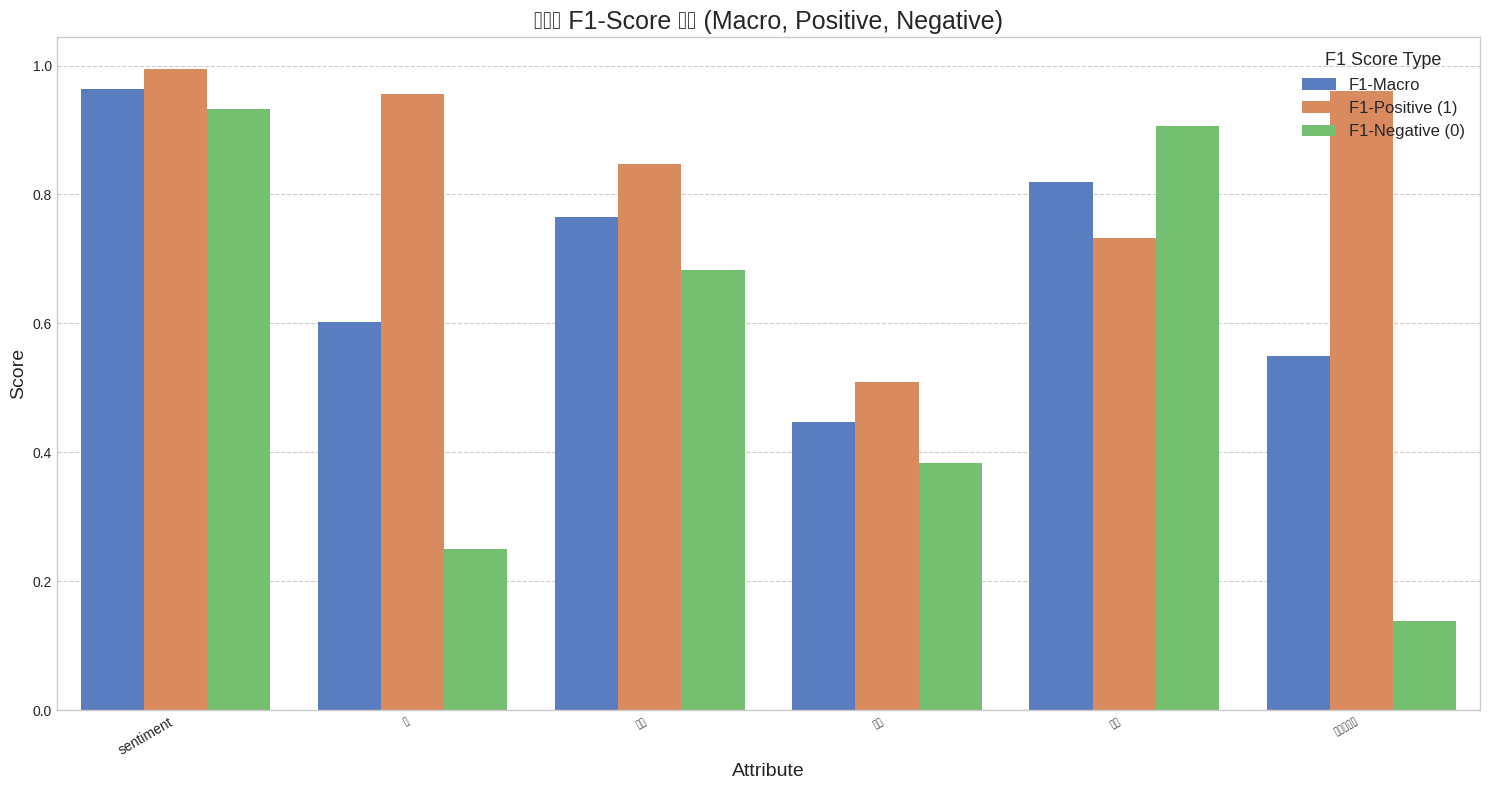

In [ ]:
# 시각화 2: 한 그래프에서 F1-Macro, F1-Positive, F1-Negative 비교
metrics_to_plot_f1 = metrics_summary_df.melt(id_vars='attribute',
                                          value_vars=['f1_macro', 'f1_class_1', 'f1_class_0'],
                                          var_name='F1_Type', value_name='Score')
metrics_to_plot_f1['F1_Type'] = metrics_to_plot_f1['F1_Type'].replace({
    'f1_macro': 'F1-Macro',
    'f1_class_1': 'F1-Positive (1)',
    'f1_class_0': 'F1-Negative (0)'
})

plt.figure(figsize=(15, 8))
sns.barplot(x='attribute', y='Score', hue='F1_Type', data=metrics_to_plot_f1, palette='muted')
plt.title('속성별 F1-Score 비교 (Macro, Positive, Negative)', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Attribute', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.legend(title='F1 Score Type', fontsize=12, title_fontsize=13, loc='upper right')
plt.grid(axis='y', linestyle='--')
# 각 막대 위에 값 표시 (너무 많으면 지저분할 수 있어 주석 처리, 필요시 해제)
# for p in plt.gca().patches:
#     height = p.get_height()
#     if height > 0.001 : # 너무 작은 값은 표시 안 함
#         plt.gca().annotate(f"{height:.3f}", (p.get_x() + p.get_width() / 2., height),
#                          ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
#                          textcoords='offset points')
plt.tight_layout()
plt.show()

<ipython-input-26-99fea1cdd6f8>:24: UserWarning: Glyph 47579 (\N{HANGUL SYLLABLE MAS}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-26-99fea1cdd6f8>:24: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-26-99fea1cdd6f8>:24: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-26-99fea1cdd6f8>:24: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-26-99fea1cdd6f8>:24: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-26-99fea1cdd6f8>:24: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-26-99fea1cdd6f8>:24: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Liberation Sans.


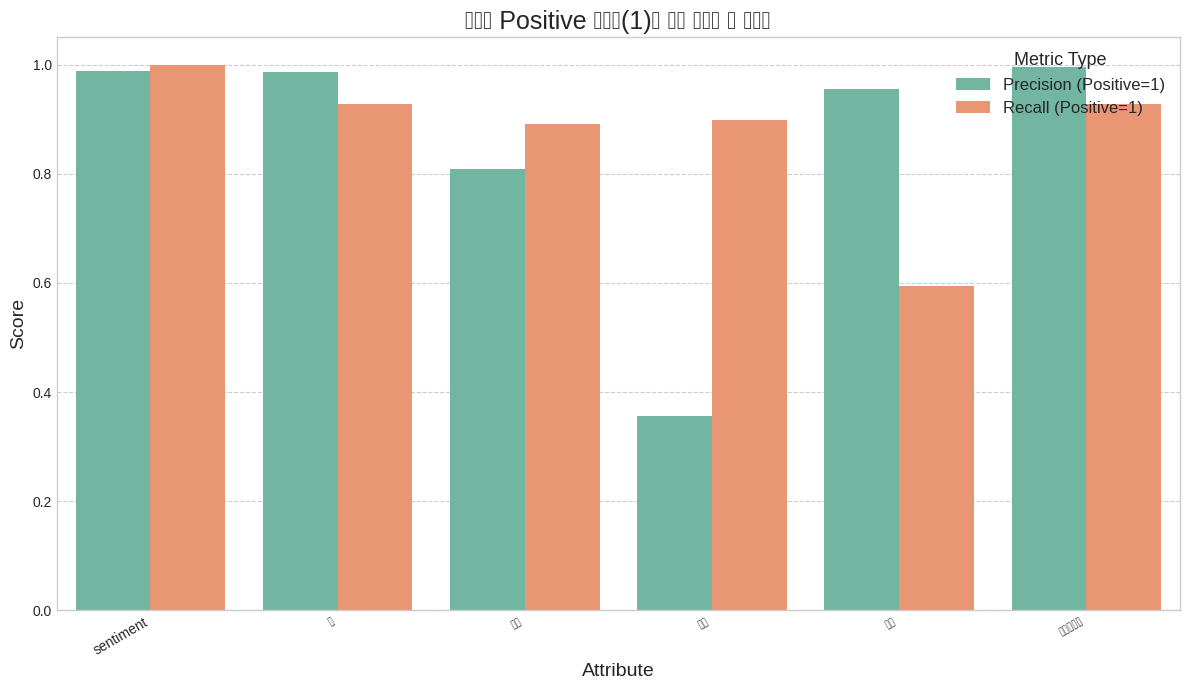


--- 시각화 참고 정보 ---
F1-Macro: 각 클래스에 동일한 가중치를 부여한 F1-Score의 평균으로, 클래스 불균형 시 유용합니다.
F1-Positive (1): 긍정으로 예측해야 할 것을 얼마나 잘 맞췄는지에 대한 F1-Score 입니다.
F1-Negative (0): 부정으로 예측해야 할 것을 얼마나 잘 맞췄는지에 대한 F1-Score 입니다.
Accuracy: 전체 예측 중 올바르게 예측한 비율입니다.
전체 속성에 대한 평균 Macro F1-Score는 0.6910 이고, 평균 Positive F1-Score는 0.8333 입니다.


In [ ]:
# 시각화 3: 정밀도 및 재현율 비교 (Positive Class = 1 기준)
metrics_pr_positive = metrics_summary_df.melt(id_vars='attribute',
                                              value_vars=['precision_class_1', 'recall_class_1'],
                                              var_name='Metric_Type', value_name='Score')
metrics_pr_positive['Metric_Type'] = metrics_pr_positive['Metric_Type'].replace({
    'precision_class_1': 'Precision (Positive=1)',
    'recall_class_1': 'Recall (Positive=1)'
})

plt.figure(figsize=(12, 7))
sns.barplot(x='attribute', y='Score', hue='Metric_Type', data=metrics_pr_positive, palette='Set2')
plt.title('속성별 Positive 클래스(1)에 대한 정밀도 및 재현율', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Attribute', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.legend(title='Metric Type', fontsize=12, title_fontsize=13, loc='upper right')
plt.grid(axis='y', linestyle='--')
# for p in plt.gca().patches: # 값 표시 (선택적)
#     height = p.get_height()
#     if height > 0.001 :
#         plt.gca().annotate(f"{height:.3f}", (p.get_x() + p.get_width() / 2., height),
#                          ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
#                          textcoords='offset points')
plt.tight_layout()
plt.show()

print("\n--- 시각화 참고 정보 ---")
print("F1-Macro: 각 클래스에 동일한 가중치를 부여한 F1-Score의 평균으로, 클래스 불균형 시 유용합니다.")
print("F1-Positive (1): 긍정으로 예측해야 할 것을 얼마나 잘 맞췄는지에 대한 F1-Score 입니다.")
print("F1-Negative (0): 부정으로 예측해야 할 것을 얼마나 잘 맞췄는지에 대한 F1-Score 입니다.")
print("Accuracy: 전체 예측 중 올바르게 예측한 비율입니다.")
print(f"전체 속성에 대한 평균 Macro F1-Score는 {avg_f1_macro_all_attributes:.4f} 이고, 평균 Positive F1-Score는 {avg_f1_positive_all_attributes:.4f} 입니다.")